<a href="https://colab.research.google.com/github/ngupta23/pycaret_faqs/blob/main/time_series/pycaret_ts_custom_model_sktime_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install & Import Library

In [1]:
try:
  import pycaret
except:
  !pip install pycaret-ts-alpha

In [2]:
import numpy as np
import pandas as pd
from pycaret.internal.pycaret_experiment import TimeSeriesExperiment
from pycaret.datasets import get_data
import matplotlib.pyplot as plt

from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.theta import ThetaForecaster

% matplotlib inline

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Get Data & Setup Experiment

In [3]:
y = get_data("airline", verbose=False)

In [4]:
exp = TimeSeriesExperiment()
exp.setup(data=y, fh=12, session_id=42)

,Description,Value
0,session_id,42
1,Original Data,"(144, 1)"
2,Missing Values,False
3,Transformed Train Set,"(132,)"
4,Transformed Test Set,"(12,)"
5,Fold Generator,ExpandingWindowSplitter
6,Fold Number,3
7,Enforce Prediction Interval,False
8,Seasonal Period Tested,12
9,Seasonality Detected,True


## Baseline Model

### Create Model

In [5]:
model = exp.create_model("theta")

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,R2
0,1956-12,23.3572,28.5971,0.0594,0.0619,0.7998,0.7338
1,1957-12,16.0904,20.9512,0.0401,0.0401,0.5263,0.8850
2,1958-12,45.5099,52.0433,0.1013,0.1080,1.5927,0.3941
Mean,NaN,28.3192,33.8639,0.0670,0.0700,0.9729,0.6710
SD,NaN,12.5124,13.2284,0.0255,0.0283,0.4522,0.2053


In [6]:
exp.predict_model(model)

,Model,MAE,RMSE,MAPE,SMAPE,MASE,R2
0,Theta Forecaster,25.4631,29.9574,0.0516,0.0523,0.8362,0.838


1960-01    412.4878
1960-02    403.3645
1960-03    464.1333
1960-04    445.8728
1960-05    449.1357
1960-06    510.9603
1960-07    563.3401
1960-08    560.9485
1960-09    491.7318
1960-10    428.4133
1960-11    372.9401
1960-12    420.1098
Freq: M, Name: Number of airline passengers, dtype: float64

In [7]:
exp.plot_model(model)

### Tune Model

In [8]:
tuned_model = exp.tune_model(model)

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,R2
0,1956-12,22.3655,27.8660,0.0570,0.0592,0.7659,0.7472
1,1957-12,15.0918,19.9555,0.0378,0.0378,0.4936,0.8957
2,1958-12,37.8295,46.4108,0.0832,0.0884,1.3239,0.5181
Mean,NaN,25.0956,31.4108,0.0593,0.0618,0.8611,0.7203
SD,NaN,9.4813,11.0874,0.0186,0.0207,0.3456,0.1553


In [9]:
exp.predict_model(tuned_model)

,Model,MAE,RMSE,MAPE,SMAPE,MASE,R2
0,Theta Forecaster,30.3134,33.5281,0.0619,0.0634,0.9955,0.7971


1960-01    407.5478
1960-02    403.4548
1960-03    457.5876
1960-04    437.1017
1960-05    436.0482
1960-06    508.8598
1960-07    561.5051
1960-08    558.8148
1960-09    481.2455
1960-10    419.2709
1960-11    366.2103
1960-12    414.6780
Freq: M, Name: Number of airline passengers, dtype: float64

In [10]:
exp.plot_model(tuned_model)

## Understanding Box-Cox Transformation

https://www.statisticshowto.com/box-cox-transformation/

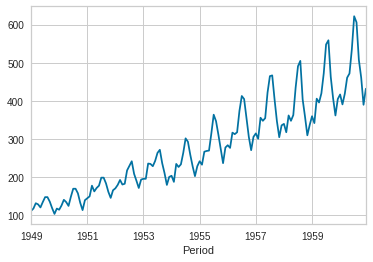

In [11]:
y.plot()

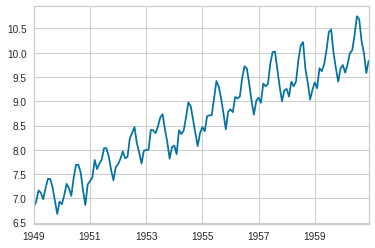

In [12]:
## Box-Cox Transformation with lambda < 1 
## Peaks are squished and Valleys are raised 
## Gives relatively uniform seasonality compared to original data
bc = BoxCoxTransformer()
y_trans = bc.fit_transform(y)
y_trans.plot()

In [13]:
# What value of lambda was selected?
bc.lambda_

0.14802265137037945

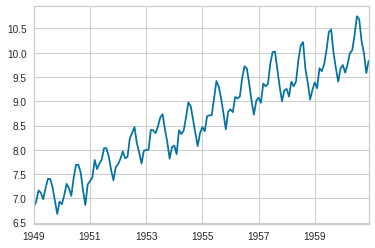

In [14]:
## Peaks are squishes and Valleys are raised -- gives uniform seasonality compared to original data
bc = BoxCoxTransformer()
y_trans = bc.fit_transform(y)
y_trans.plot()

## Create and Tune with **custom** pipeline

### Define your **custom** pipeline!

In [15]:
#### Create a sktime pipeline with preprocessing ----
my_forecaster = TransformedTargetForecaster(
    [
        ("bc", BoxCoxTransformer(sp=12)),
        ("model", ThetaForecaster(deseasonalize=True, sp=12)),
    ]
)

### Create Custom Pipeline Model

In [16]:
custom_model = exp.create_model(my_forecaster)

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,R2
0,1956-12,14.4351,17.0857,0.0376,0.0384,0.4943,0.9050
1,1957-12,17.9107,21.9331,0.0492,0.0475,0.5858,0.8740
2,1958-12,34.8424,40.8207,0.0776,0.0817,1.2194,0.6272
Mean,NaN,22.3961,26.6131,0.0548,0.0559,0.7665,0.8021
SD,NaN,8.9145,10.2393,0.0168,0.0187,0.3224,0.1243


In [17]:
exp.predict_model(custom_model)

,Model,MAE,RMSE,MAPE,SMAPE,MASE,R2
0,Theta Forecaster,15.9977,22.4668,0.0339,0.0335,0.5254,0.9089


1960-01    415.6499
1960-02    407.7339
1960-03    475.8263
1960-04    456.1295
1960-05    459.3268
1960-06    527.4749
1960-07    587.2213
1960-08    585.0710
1960-09    508.7376
1960-10    438.5744
1960-11    377.6108
1960-12    431.2662
Freq: M, Name: Number of airline passengers, dtype: float64

In [18]:
exp.plot_model(custom_model)

### Tune Custom Pipeline Model

In [19]:
my_grid = {"bc__bounds": [(-3, 0), (0, 1), (1, 3)]}
tuned_custom_model, tuner = exp.tune_model(custom_model, custom_grid=my_grid, return_tuner=True)

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,R2
0,1956-12,14.4351,17.0857,0.0376,0.0384,0.4943,0.9050
1,1957-12,17.9107,21.9331,0.0492,0.0475,0.5858,0.8740
2,1958-12,32.7888,38.5968,0.0732,0.0769,1.1475,0.6667
Mean,NaN,21.7116,25.8718,0.0534,0.0543,0.7426,0.8152
SD,NaN,7.9603,9.2129,0.0148,0.0164,0.2888,0.1058


In [20]:
pd.DataFrame(tuner.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bc__bounds,params,split0_test_smape,split1_test_smape,split2_test_smape,mean_test_smape,std_test_smape,rank_test_smape
0,0.029744,0.012948,0.000745,0.000008,"(-3, 0)","{'bc__bounds': (-3, 0)}",0.038397,0.047528,0.076944,0.054290,0.016447,1
1,0.022475,0.008106,0.000807,0.000163,"(0, 1)","{'bc__bounds': (0, 1)}",0.038972,0.047246,0.081746,0.055988,0.018524,2
2,0.015429,0.003065,0.001820,0.001719,"(1, 3)","{'bc__bounds': (1, 3)}",0.061647,0.040058,0.107707,0.069804,0.028213,3


In [21]:
# What value of lambda was selected?
print(tuned_custom_model.steps_[0][1].lambda_)

-3.4972054492990284e-06


In [22]:
exp.predict_model(tuned_custom_model)

,Model,MAE,RMSE,MAPE,SMAPE,MASE,R2
0,Theta Forecaster,13.9917,21.3391,0.0307,0.03,0.4595,0.9178


1960-01    416.5504
1960-02    408.9021
1960-03    480.1220
1960-04    459.4622
1960-05    462.5578
1960-06    533.8071
1960-07    597.5431
1960-08    595.3193
1960-09    514.8793
1960-10    441.1007
1960-11    377.5175
1960-12    433.8549
Freq: M, Name: Number of airline passengers, dtype: float64

In [23]:
exp.plot_model(tuned_custom_model)